<a href="https://colab.research.google.com/github/mohamedabdo556/StockPredictAI/blob/main/StockPredictAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# تحميل المكتبات الأساسية
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler


In [2]:
# تحميل بيانات أسعار الأسهم (مثال باستخدام بيانات من Yahoo Finance)
!pip install yfinance
import yfinance as yf

# تحميل بيانات سهم معين مثل Tesla
data = yf.download('TSLA', start='2010-01-01', end='2024-01-01')
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


In [3]:
# عرض وصف إحصائي للبيانات
data.describe()


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3.400000e+03
mean,70.474242,70.474242,72.048393,68.819973,70.493993,9.681167e+07
std,101.480831,101.480831,103.824949,99.066386,101.559061,8.004848e+07
min,1.053333,1.053333,1.108667,0.998667,1.076000,1.777500e+06
25%,10.779833,10.779833,11.014167,10.417333,10.722500,4.598775e+07
50%,16.928666,16.928666,17.218667,16.679334,16.944000,8.122500e+07
75%,108.349998,108.349998,111.962500,104.220999,109.584000,1.235249e+08
max,409.970001,409.970001,414.496674,405.666656,411.470001,9.140820e+08


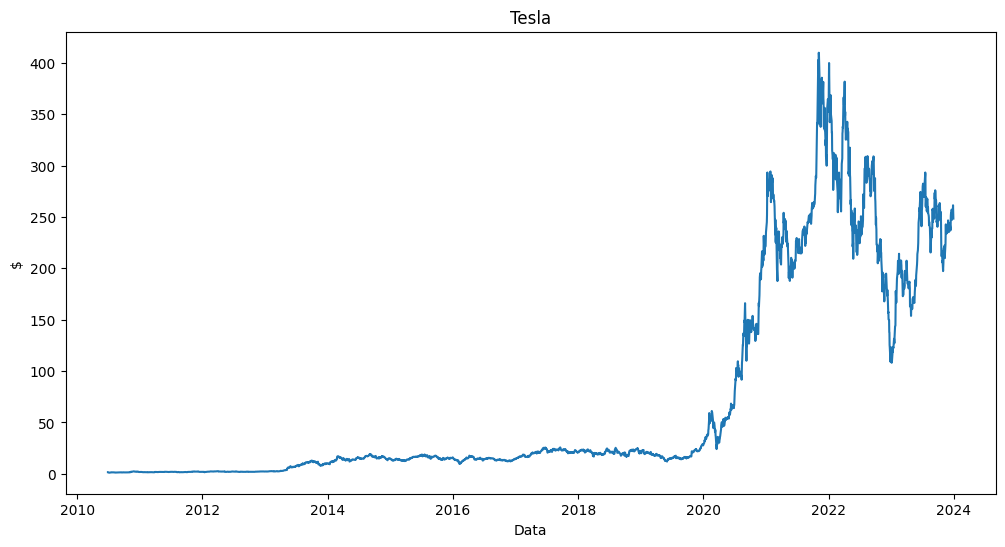

In [4]:
# رسم الأسعار التاريخية
plt.figure(figsize=(12,6))
plt.title('Tesla')
plt.plot(data['Close'])
plt.xlabel('Data')
plt.ylabel('$')
plt.show()


In [5]:
# استخدام سعر الإغلاق فقط
prices = data['Close'].values.reshape(-1, 1)

# تطبيع البيانات
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# تقسيم البيانات إلى تدريب واختبار
train_size = int(len(scaled_prices) * 0.8)
train_data, test_data = scaled_prices[:train_size], scaled_prices[train_size:]

# إعداد بيانات السلاسل الزمنية
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# تغيير الأبعاد لتناسب LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [6]:
# بناء النموذج
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# تجميع النموذج
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# تدريب النموذج
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2617e-04 - val_loss: 0.0044
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9727e-04 - val_loss: 0.0027
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5066e-04 - val_loss: 0.0032
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3654e-04 - val_loss: 0.0023
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2614e-04 - val_loss: 0.0030
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2216e-04 - val_loss: 0.0025
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6505e-04 - val_loss: 0.0020
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1097e-04 - val_loss: 0.0019
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2529e-04 - val_loss: 0.0028
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0813e-04 - val_loss: 0.0019
Epoch 12/50
42/42 ━━━━━━━━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


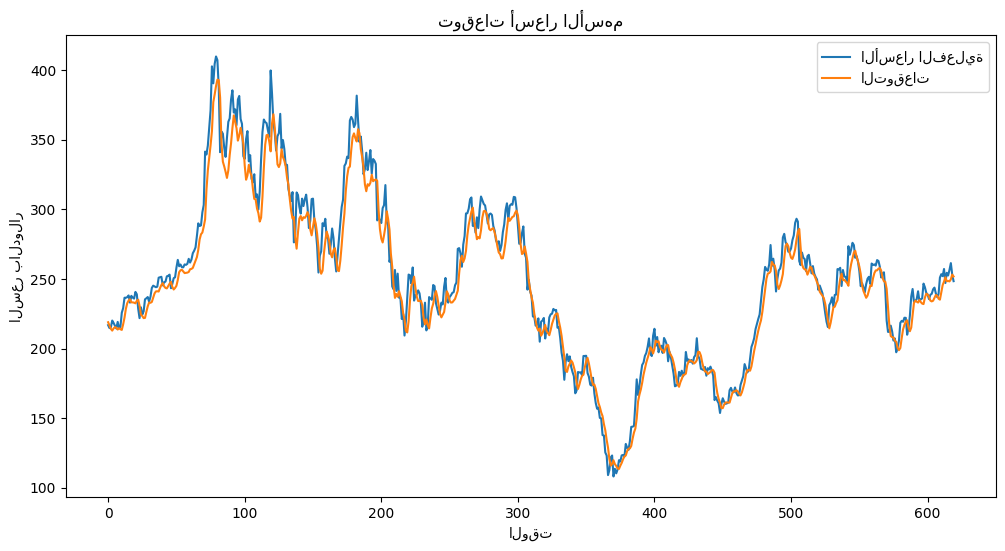

In [8]:
# التنبؤ على بيانات الاختبار
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# إعادة البيانات الأصلية للاختبار
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# رسم النتائج
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='الأسعار الفعلية')
plt.plot(predictions, label='التوقعات')
plt.title('توقعات أسعار الأسهم')
plt.xlabel('الوقت')
plt.ylabel('السعر بالدولار')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_prices, predictions)
mae = mean_absolute_error(actual_prices, predictions)
print(f'الخطأ التربيعي المتوسط MSE: {mse:.4f}')
print(f'الخطأ المطلق المتوسط MAE: {mae:.4f}')


الخطأ التربيعي المتوسط MSE: 159.0884
الخطأ المطلق المتوسط MAE: 9.4466


بعض التحسينات


In [10]:
# تحميل بيانات متعددة من أسواق مختلفة
assets = ['TSLA', 'AAPL', 'MSFT', 'GOOGL']

# تحميل بيانات جميع الأسهم
data = {}
for asset in assets:
    data[asset] = yf.download(asset, start='2000-01-01', end='2024-12-01')

# عرض أول خمس صفوف من بيانات TSLA
data['TSLA'].head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


In [11]:
# إضافة متوسط متحرك ومؤشرات فنية
for asset in assets:
    df = data[asset]
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=30).std()
    data[asset] = df

# عرض البيانات مع المؤشرات
data['TSLA'].tail()


Price,Adj Close,Close,High,Low,Open,Volume,SMA_50,SMA_200,Volatility
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,,,
Date,,,,,,,,,
2024-11-22,352.559998,352.559998,361.529999,337.700012,341.089996,89140700,264.0618,211.83050,0.057127
2024-11-25,338.589996,338.589996,361.929993,338.200012,360.140015,95890900,266.2980,212.55560,0.058049
2024-11-26,338.230011,338.230011,346.959991,335.660004,341.000000,62295900,268.5052,213.30610,0.058076
2024-11-27,332.890015,332.890015,342.549988,326.589996,341.799988,57896400,270.6190,214.05045,0.058351
2024-11-29,345.160004,345.160004,345.450012,334.649994,336.079987,37167600,272.6438,214.83270,0.058387


In [12]:
# استخدام ميزات متعددة
features = ['Close', 'SMA_50', 'SMA_200', 'Volatility']

# تطبيع البيانات
def scale_data(df, features):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features].fillna(0))
    return scaled_data, scaler

# تقسيم البيانات لكل سهم
scaled_data = {}
scalers = {}
for asset in assets:
    scaled_data[asset], scalers[asset] = scale_data(data[asset], features)

# تجهيز بيانات السلاسل الزمنية
def create_multifeature_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i])
        y.append(dataset[i, 0])  # التنبؤ بسعر الإغلاق
    return np.array(X), np.array(y)


In [13]:
# تقسيم البيانات
train_size = 0.8

X_train, y_train, X_test, y_test = {}, {}, {}, {}
for asset in assets:
    train_len = int(len(scaled_data[asset]) * train_size)
    X, y = create_multifeature_dataset(scaled_data[asset])
    X_train[asset], y_train[asset] = X[:train_len], y[:train_len]
    X_test[asset], y_test[asset] = X[train_len:], y[train_len:]

# تغيير الأبعاد لتتناسب مع LSTM
for asset in assets:
    X_train[asset] = X_train[asset].reshape(X_train[asset].shape[0], X_train[asset].shape[1], len(features))
    X_test[asset] = X_test[asset].reshape(X_test[asset].shape[0], X_test[asset].shape[1], len(features))


In [14]:
# نموذج محسّن مع طبقات إضافية
def build_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        LSTM(100, return_sequences=False),
        Dense(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# بناء النموذج لأسهم متعددة
models = {asset: build_model((X_train[asset].shape[1], X_train[asset].shape[2])) for asset in assets}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# تدريب جميع النماذج
for asset in assets:
    print(f'تدريب النموذج على {asset}...')
    models[asset].fit(X_train[asset], y_train[asset], epochs=50, batch_size=64, validation_data=(X_test[asset], y_test[asset]))


تدريب النموذج على TSLA...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9013e-04 - val_loss: 0.0030
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6348e-04 - val_loss: 0.0043
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4323e-04 - val_loss: 0.0042
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0039e-04 - val_loss: 0.0039
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4302e-04 - val_loss: 0.0023
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1669e-04 - val_loss: 0.0030
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6338e-04 - val_loss: 0.0019
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4355e-04 - val_loss: 0.0089
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4163e-04 - val_loss: 0.0016
E

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


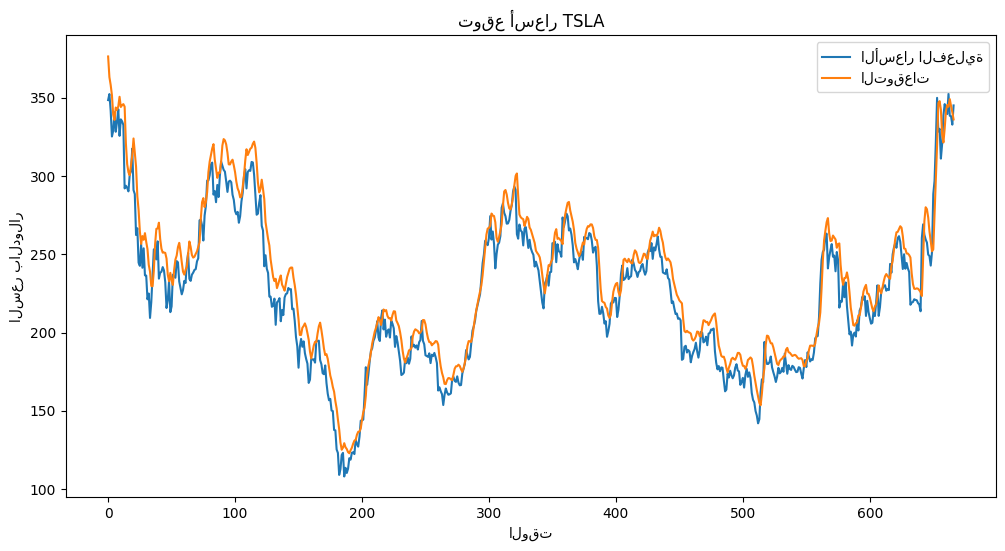

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


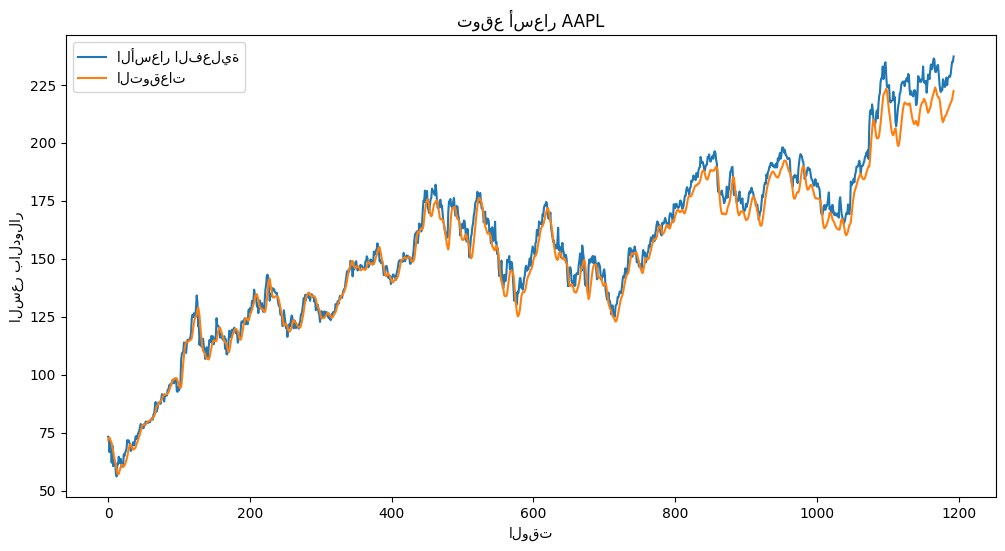

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


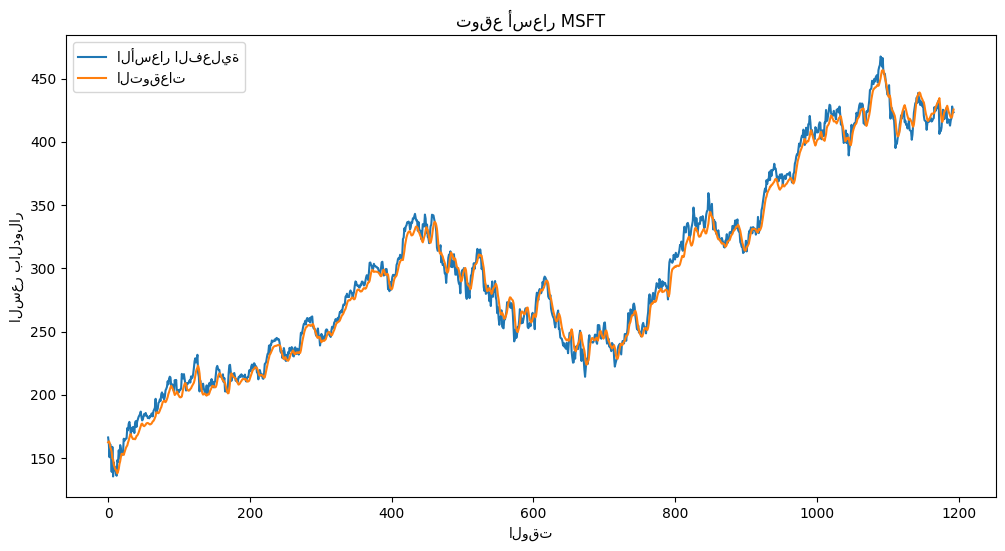

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


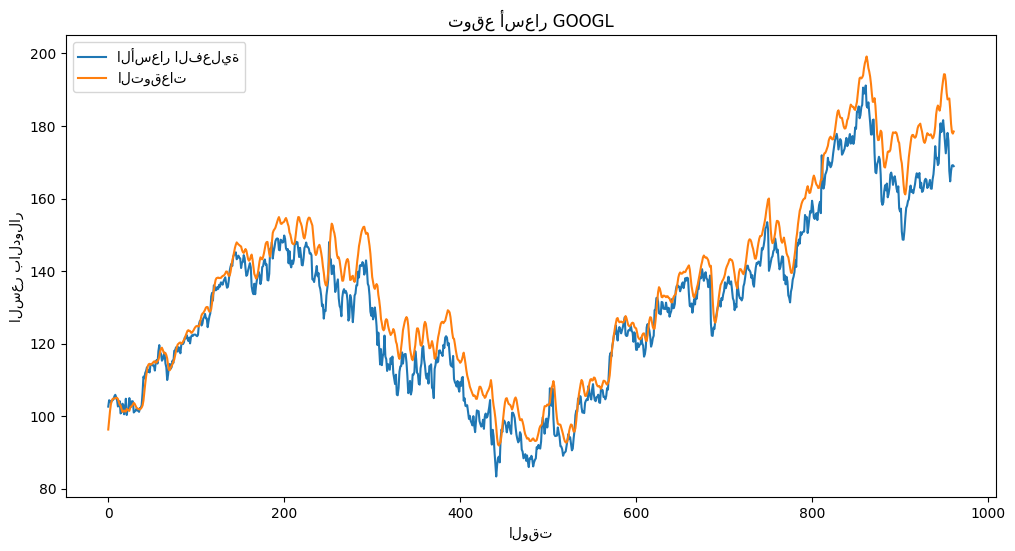

In [16]:
for asset in assets:
    # التنبؤ بالأسعار
    predictions = models[asset].predict(X_test[asset])

    # اختيار العمود الأول فقط أثناء إعادة التطبيع
    predictions = scalers[asset].inverse_transform(
        np.concatenate((predictions, np.zeros((predictions.shape[0], len(features) - 1))), axis=1)
    )[:, 0]

    # إعادة السعر الفعلي
    actual_prices = scalers[asset].inverse_transform(
        np.concatenate((y_test[asset].reshape(-1, 1), np.zeros((y_test[asset].shape[0], len(features) - 1))), axis=1)
    )[:, 0]

    # رسم النتائج
    plt.figure(figsize=(12, 6))
    plt.title(f'توقع أسعار {asset}')
    plt.plot(actual_prices, label='الأسعار الفعلية')
    plt.plot(predictions, label='التوقعات')
    plt.xlabel('الوقت')
    plt.ylabel('السعر بالدولار')
    plt.legend()
    plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for asset in assets:
    # التنبؤ بالأسعار
    predictions = models[asset].predict(X_test[asset])

    # إعادة التنبؤات إلى القيم الفعلية
    predictions = scalers[asset].inverse_transform(
        np.concatenate((predictions, np.zeros((predictions.shape[0], len(features) - 1))), axis=1)
    )[:, 0]

    # إعادة القيم الفعلية
    actual_prices = scalers[asset].inverse_transform(
        np.concatenate((y_test[asset].reshape(-1, 1), np.zeros((y_test[asset].shape[0], len(features) - 1))), axis=1)
    )[:, 0]

    # حساب الأخطاء
    mse = mean_squared_error(actual_prices, predictions)
    mae = mean_absolute_error(actual_prices, predictions)
    r2 = r2_score(actual_prices, predictions)

    print(f'نتائج {asset}:')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R^2: {r2:.4f}\n')


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
نتائج TSLA:
MSE: 205.8716
MAE: 11.7020
R^2: 0.9104

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
نتائج AAPL:
MSE: 37.8620
MAE: 4.6578
R^2: 0.9738

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
نتائج MSFT:
MSE: 57.7172
MAE: 6.1292
R^2: 0.9901

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
نتائج GOOGL:
MSE: 55.4324
MAE: 6.0809
R^2: 0.9042



## المرحلة 1: دمج بيانات اقتصادية إضافية

In [18]:
# تحميل بيانات اقتصادية مثل مؤشر S&P 500
sp500 = yf.download('^GSPC', start='2000-01-01', end='2024-12-01')

# دمج البيانات مع بيانات الأسهم
for asset in assets:
    data[asset]['SP500_Close'] = sp500['Close']


[*********************100%***********************]  1 of 1 completed


## المرحلة 2: تحليل المعنويات باستخدام الأخبار

## لتشغيل الكود الاتي ادخل علي https://newsapi.org/ واحصل علي API وضعه مكانYOUR_API_KEY

In [21]:
!pip install newsapi-python

In [23]:
from newsapi import NewsApiClient
from textblob import TextBlob
import numpy as np

# إعداد واجهة الأخبار
newsapi = NewsApiClient(api_key='838e6b2793654fd18829fb19bd2cdb6d')

def fetch_sentiment(query):
    articles = newsapi.get_everything(q=query, language='en', sort_by='relevancy')
    sentiments = [TextBlob(article['description']).sentiment.polarity
                  for article in articles['articles'] if article['description']]
    return np.mean(sentiments) if sentiments else 0

# إضافة معنويات أخبار لكل سهم
for asset in assets:
    sentiment = fetch_sentiment(asset)
    data[asset]['Sentiment'] = sentiment


## المرحلة 3: تحسين نموذج LSTM بتأثير المعنويات

In [24]:
features = ['Close', 'SMA_50', 'SMA_200', 'Volatility', 'SP500_Close', 'Sentiment']

# تطبيع البيانات وتوسيع المدخلات
scaled_data = {}
scalers = {}
for asset in assets:
    scaled_data[asset], scalers[asset] = scale_data(data[asset], features)

# تجهيز البيانات الزمنية
def create_advanced_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)


## بلوك 4: بناء نموذج LSTM المتقدم

In [25]:
# بناء نموذج أكثر تعقيدًا
def build_advanced_model(input_shape):
    model = Sequential([
        LSTM(150, return_sequences=True, input_shape=input_shape),
        LSTM(150, return_sequences=True),
        LSTM(100, return_sequences=False),
        Dense(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# تدريب النموذج
advanced_models = {asset: build_advanced_model((X_train[asset].shape[1], X_train[asset].shape[2])) for asset in assets}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## بلوك 5: التدريب والتحسين **المستمر**

In [26]:
# تدريب النموذج المحسن
for asset in assets:
    print(f'تدريب النموذج المتقدم على {asset}...')
    advanced_models[asset].fit(X_train[asset], y_train[asset], epochs=100, batch_size=64, validation_data=(X_test[asset], y_test[asset]))


تدريب النموذج المتقدم على TSLA...
Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0075 - val_loss: 0.0091
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.2381e-04 - val_loss: 0.0061
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.3364e-04 - val_loss: 0.0032
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.0303e-04 - val_loss: 0.0103
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.4424e-04 - val_loss: 0.0026
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.8572e-04 - val_loss: 0.0025
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.7095e-04 - val_loss: 0.0038
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8622e-04 - val_loss: 0.0027
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7820e-04 - val_loss: 0.0054
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8337e-04 -

## المرحلة 4: التنبؤ الذكي وتقييم التحليل

In [27]:
print(f"{asset} - شكل التوقعات: {predictions.shape}")


GOOGL - شكل التوقعات: (962,)


In [31]:
predictions = predictions.reshape(-1, 1)

In [32]:
# إعادة ضبط المحول على الأعمدة الصحيحة
scalers[asset] = MinMaxScaler(feature_range=(0, 1))
scalers[asset].fit(y_train[asset].reshape(-1, 1))


MinMaxScaler()

In [33]:
for asset in assets:
    # توقع الأسعار
    predictions = advanced_models[asset].predict(X_test[asset])

    # تأكد من أن التوقعات تتطابق مع عدد الأعمدة الأصلية
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)

    # الحصول على عدد الميزات من بيانات التدريب
    feature_count = X_train[asset].shape[1]

    # إضافة الأعمدة المفقودة لتطابق شكل بيانات التحجيم الأصلية
    padded_predictions = np.zeros((predictions.shape[0], feature_count))
    padded_predictions[:, 0] = predictions[:, 0]

    # عكس التحجيم فقط للأعمدة الصحيحة
    predictions_scaled = scalers[asset].inverse_transform(padded_predictions[:, :feature_count])[:, 0]

    # عكس التحجيم للأسعار الفعلية أيضًا
    actual_prices = scalers[asset].inverse_transform(
        np.concatenate([y_test[asset].reshape(-1, 1), np.zeros((y_test[asset].shape[0], feature_count - 1))], axis=1)
    )[:, 0]

    # عرض التوقعات لكل سهم بشكل منفصل
    plt.figure(figsize=(14, 7))
    plt.title(f'توقع أسعار {asset} مع التحليل المتقدم')
    plt.plot(actual_prices, label='الأسعار الفعلية')
    plt.plot(predictions_scaled, label='التوقعات')
    plt.xlabel('الوقت')
    plt.ylabel('السعر بالدولار')
    plt.legend()
    plt.show()

    # حساب دقة الاتجاه لكل سهم بشكل منفصل
    trend_accuracy = np.mean(
        (predictions_scaled[:-1] > actual_prices[:-1]) == (np.diff(actual_prices, axis=0) > 0)
    )
    print(f'دقة الاتجاه لسهم {asset}: {trend_accuracy * 100:.2f}%')


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


ValueError: operands could not be broadcast together with shapes (667,60) (6,) (667,60) 

### انشاء نموذج LSTM

In [35]:
# تثبيت المكتبات المطلوبة
!pip install yfinance numpy pandas matplotlib scikit-learn tensorflow

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# تحميل البيانات
def load_data(stock_symbol):
    # تحميل البيانات من Yahoo Finance
    data = yf.download(stock_symbol, start="2010-01-01", end="2024-01-01")
    return data

# تجهيز البيانات للتدريب
def prepare_data(data, look_back=60):
    # استخدم فقط أسعار الإغلاق
    closing_prices = data['Close'].values
    closing_prices = closing_prices.reshape(-1, 1)

    # تحجيم البيانات بين 0 و 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closing_prices)

    # إنشاء بيانات الإدخال والمخرجات
    X_data, y_data = [], []
    for i in range(look_back, len(scaled_data)):
        X_data.append(scaled_data[i-look_back:i, 0])  # بيانات الإدخال (الـ look_back الأيام الماضية)
        y_data.append(scaled_data[i, 0])  # البيانات المستهدفة (السعر التالي)

    X_data, y_data = np.array(X_data), np.array(y_data)

    # تشكيل البيانات بشكل مناسب لنموذج LSTM
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1))

    return X_data, y_data, scaler

# بناء النموذج LSTM
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))  # مخرج واحد هو السعر المتوقع
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# تدريب النموذج
def train_model(model, X_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])

# اختبار النموذج
def test_model(model, data, look_back=60):
    # استخدام آخر 60 يومًا للتنبؤ بالسعر التالي
    inputs = data['Close'].values
    inputs = inputs.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_inputs = scaler.fit_transform(inputs)

    X_test = []
    X_test.append(scaled_inputs[-look_back:])  # آخر 60 يومًا

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_price = model.predict(X_test)
    predicted_price = scaler.inverse_transform(predicted_price)
    return predicted_price[0][0]

# تحميل البيانات
stock_symbol = "TSLA"  # اختر السهم (مثل TSLA)
data = load_data(stock_symbol)

# تجهيز البيانات
look_back = 60
X_data, y_data, scaler = prepare_data(data, look_back)

# تقسيم البيانات إلى تدريب واختبار
train_size = int(len(X_data) * 0.8)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# بناء النموذج
model = build_model((X_train.shape[1], 1))

# تدريب النموذج
train_model(model, X_train, y_train)

# اختبار النموذج
predicted_price = test_model(model, data, look_back)

# عرض السعر المتوقع
print(f"السعر المتوقع للسهم {stock_symbol} في اليوم التالي: {predicted_price:.2f} دولار")


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9102e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2782e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6640e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5761e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.2944e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1860e-04
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4402e-04
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9262e-05
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3895e-04
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1538e-05
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7783e-05
Epoch 13/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5090e-05
Epoch 14/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2461e-05
Epoch 15/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s

In [36]:
# حفظ النموذج باستخدام التنسيق الجديد
model.save("stock_price_model.keras")


In [41]:
from tensorflow.keras.models import load_model

# تحميل النموذج المحفوظ
model = load_model("stock_price_model.keras")


In [43]:
# تثبيت المكتبات
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# إنشاء بيانات تاريخية (افتراضية)
data = {
    "Date": ["2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04", "2023-01-05",
             "2023-01-06", "2023-01-07", "2023-01-08", "2023-01-09", "2023-01-10"],
    "Close": [150, 152, 153, 155, 157, 158, 160, 162, 164, 165]
}

# تحويل البيانات إلى DataFrame
df = pd.DataFrame(data)

# عرض نظرة عامة على البيانات
print(df)

# معالجة البيانات
closing_prices = df['Close'].values.reshape(-1, 1)

# مقياس البيانات
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

# إعداد بيانات التدريب
def create_dataset(data, look_back=3):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_dataset(closing_prices_scaled, look_back)

# تقسيم البيانات إلى تدريب واختبار
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# إعادة تشكيل البيانات
X_train = X_train.reshape(X_train.shape[0], look_back, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1)

print(f"أشكال البيانات: X_train={X_train.shape}, y_train={y_train.shape}")


         Date  Close
0  2023-01-01    150
1  2023-01-02    152
2  2023-01-03    153
3  2023-01-04    155
4  2023-01-05    157
5  2023-01-06    158
6  2023-01-07    160
7  2023-01-08    162
8  2023-01-09    164
9  2023-01-10    165
أشكال البيانات: X_train=(5, 3, 1), y_train=(5, 1)


In [44]:
# بناء النموذج
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# تجميع النموذج
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 3, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# تدريب النموذج
history = model.fit(X_train, y_train, epochs=50, batch_size=2, validation_data=(X_test, y_test))


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 0.3427 - val_loss: 0.7875
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2577 - val_loss: 0.6540
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2254 - val_loss: 0.5048
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1512 - val_loss: 0.3470
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1021 - val_loss: 0.1840
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0418 - val_loss: 0.0515
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0075 - val_loss: 9.3716e-04
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0084 - val_loss: 0.0327
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0378 - val_loss: 0.0225
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0177 - val_loss: 0.0013
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0084
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033 - val_loss: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0014
خسارة النموذج: 0.0013619584497064352


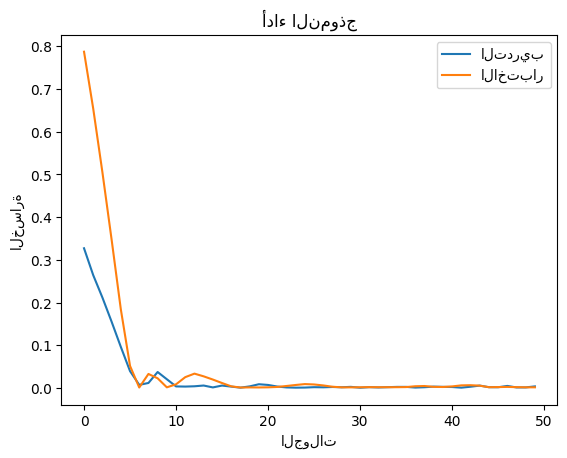

In [47]:
# التقييم
loss = model.evaluate(X_test, y_test)
print(f"خسارة النموذج: {loss}")

# عرض الرسم البياني للأداء
plt.plot(history.history['loss'], label='التدريب')
plt.plot(history.history['val_loss'], label='الاختبار')
plt.title('أداء النموذج')
plt.xlabel('الجولات')
plt.ylabel('الخسارة')
plt.legend()
plt.show()


In [48]:
# حفظ النموذج المحسن
model.save('/content/stock_price_model_improved.keras')
print("تم حفظ النموذج بنجاح!")


تم حفظ النموذج بنجاح!


In [54]:
# تثبيت المكتبات
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import datetime
from ipywidgets import interact
import yfinance as yf

# تحميل النموذج
model = load_model('/content/stock_price_model_improved.keras')  # استبدل بمسار النموذج

# الأسهم المتاحة
assets = ['TSLA', 'AAPL', 'GOOG', 'AMZN', 'MSFT']

# دالة التنبؤ
def predict_stock(asset, look_back=60):
    if asset not in assets:
        return "السهم غير مدعوم."

    # تحميل البيانات التاريخية من Yahoo Finance
    try:
        stock_data = yf.download(asset, start="2022-01-01", end=datetime.datetime.now().strftime("%Y-%m-%d"))
        closing_prices = stock_data['Close'].values
    except Exception as e:
        return f"حدث خطأ في تحميل البيانات: {e}"

    # معالجة البيانات
    scaler = MinMaxScaler(feature_range=(0, 1))
    closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))

    # التحقق من كفاية البيانات
    if len(closing_prices_scaled) < look_back:
        return "عدد البيانات التاريخية غير كافٍ لإجراء التنبؤ."

    # إعداد البيانات للنموذج
    X_input = closing_prices_scaled[-look_back:].reshape(1, look_back, 1)
    prediction = model.predict(X_input)

    # تأكد من استخراج أول قيمة صحيحة من المصفوفة
    predicted_price = float(scaler.inverse_transform(prediction)[0][0])
    current_price = float(closing_prices[-1])

    # تحديد الاتجاه
    trend = "يرتفع" if predicted_price > current_price else "ينخفض"

    # عرض النتائج
    return {
        "السهم": asset,
        "السعر الحالي": f"{current_price:.2f}",
        "السعر المتوقع": f"{predicted_price:.2f}",
        "الاتجاه المتوقع": trend,
        "التاريخ": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

# واجهة المستخدم
interact(predict_stock, asset=assets)


interactive(children=(Dropdown(description='asset', options=('TSLA', 'AAPL', 'GOOG', 'AMZN', 'MSFT'), value='T…

<function __main__.predict_stock(asset, look_back=60)>